In [1]:
from Data_Preprocessing import Load_Downsize_SaveAsH5 as cvt

import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


### partial data with Top as target

In [2]:
filePath = './data/'
features = ['j_index','j1_phirel','j1_etarel','j1_phirot','j1_etarot','j1_deltaR','j1_pdgid','j1_pt','j1_ptrel','j1_erel'] 
labels = ['j_g','j_q','j_w','j_z','j_t']
# ratio=[.25,.25,.25,.25,1]
size=2000
seed=42


In [4]:
cvt.LoadTransSave(filePath,features, labels,size=size,seed=seed)

### prepare data

In [5]:
cols = dict(zip(features+['constituents_index'], [i for i in range(len(features)+1)]))

features_list = ['j1_ptrel','j1_etarot','j1_phirot','j1_phirel','j1_etarel','j1_erel','j1_deltaR','j1_pdgid']

def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[],'label':[]}
    f = h5py.File(h5path,'r')
    raw_data = np.array([f[col][()] for col in cols])
    label_arr = f['label'][()]
    raw_data = raw_data.transpose((1,0))
    mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2)) # prepare constituents list
    for i in range(len(raw_data)):
        cIndex = int(raw_data[i][cols['constituents_index']])
        if cIndex >= 100:                                               # skip when excess 100 particles
            continue
        
        mask[cIndex] = [1]                                             # no mask for now
        points[cIndex] = np.array([raw_data[i][cols['j1_etarel']],raw_data[i][cols['j1_phirel']]])
        features[cIndex] = np.array([raw_data[i][cols[feat]] for feat in features_list])
                
        if i < len(raw_data)-1:
            if raw_data[i][cols['j_index']] != raw_data[i+1][cols['j_index']] : # save the jet before switch to another
                Data['mask'].append(mask)
                Data['points'].append(points)
                Data['features'].append(features)
                Data['label'].append(label_arr[i])
                mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2))  
    f.close()
    y = Data.pop('label')
    return Data, y

def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total

def separatedata(Data,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = Data["mask"]
    features = Data["features"]
    points = Data["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test)

In [6]:
h5Path = "data/data_2000jets_5labels.h5"
Data,y = h5_to_data(h5Path)
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

check shape:  (100, 1) (100, 2) (100, 8)


In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(Data,y,0.25,0.25)

In [8]:
import sys
sys.path.insert(0,'models')
from tf_keras_model import get_particle_net_lite

In [14]:
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}
num_classes = 5
model = get_particle_net_lite(num_classes, input_shapes)

In [21]:
batch_size = 1024
epochs = 300

In [26]:
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual_1 (TensorF [(None, 100, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast_2 (TensorFlowO [(None, 100, 1)]     0           tf_op_layer_NotEqual_1[0][0]     
__________________________________________________________________________________________________
tf_op_layer_Equal_1 (TensorFlow [(None, 100, 1)]     0           tf_op_layer_Cast_2[0][0]         
________________________________________________________________________________________

In [27]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [29]:
history = model.fit(X_train ,y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True,
        callbacks = None)
model.evaluate(X_test,  y_test, verbose=2)

Train on 4488 samples, validate on 2244 samples
Epoch 1/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 1.0137 - accuracy: 0.5882 - val_loss: 1.1223 - val_accuracy: 0.5651
Epoch 2/300
4488/4488 [==============================] - 19s 4ms/sample - loss: 1.0104 - accuracy: 0.5987 - val_loss: 1.1151 - val_accuracy: 0.5686
Epoch 3/300
4488/4488 [==============================] - 19s 4ms/sample - loss: 1.0055 - accuracy: 0.6003 - val_loss: 1.1086 - val_accuracy: 0.5740
Epoch 4/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 1.0114 - accuracy: 0.5958 - val_loss: 1.1002 - val_accuracy: 0.5793
Epoch 5/300
4488/4488 [==============================] - 19s 4ms/sample - loss: 1.0050 - accuracy: 0.5994 - val_loss: 1.0945 - val_accuracy: 0.5873
Epoch 6/300
4488/4488 [==============================] - 21s 5ms/sample - loss: 1.0053 - accuracy: 0.6047 - val_loss: 1.0882 - val_accuracy: 0.5891
Epoch 7/300
4488/4488 [==============================] - 20s 4ms

Epoch 56/300
4488/4488 [==============================] - 20s 5ms/sample - loss: 0.9359 - accuracy: 0.6368 - val_loss: 0.9358 - val_accuracy: 0.6631
Epoch 57/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.9368 - accuracy: 0.6326 - val_loss: 0.9346 - val_accuracy: 0.6613
Epoch 58/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.9340 - accuracy: 0.6395 - val_loss: 0.9327 - val_accuracy: 0.6622
Epoch 59/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.9367 - accuracy: 0.6297 - val_loss: 0.9315 - val_accuracy: 0.6622
Epoch 60/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.9299 - accuracy: 0.6355 - val_loss: 0.9303 - val_accuracy: 0.6653
Epoch 61/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.9344 - accuracy: 0.6308 - val_loss: 0.9296 - val_accuracy: 0.6649
Epoch 62/300
4488/4488 [==============================] - 20s 5ms/sample - loss: 0.9316 - accuracy: 0.6366

Epoch 111/300
4488/4488 [==============================] - 19s 4ms/sample - loss: 0.8814 - accuracy: 0.6667 - val_loss: 0.8901 - val_accuracy: 0.6889
Epoch 112/300
4488/4488 [==============================] - 19s 4ms/sample - loss: 0.8815 - accuracy: 0.6702 - val_loss: 0.8910 - val_accuracy: 0.6898
Epoch 113/300
4488/4488 [==============================] - 19s 4ms/sample - loss: 0.8805 - accuracy: 0.6662 - val_loss: 0.8904 - val_accuracy: 0.6867
Epoch 114/300
4488/4488 [==============================] - 19s 4ms/sample - loss: 0.8804 - accuracy: 0.6622 - val_loss: 0.8889 - val_accuracy: 0.6845
Epoch 115/300
4488/4488 [==============================] - 19s 4ms/sample - loss: 0.8757 - accuracy: 0.6740 - val_loss: 0.8876 - val_accuracy: 0.6881
Epoch 116/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.8750 - accuracy: 0.6720 - val_loss: 0.8866 - val_accuracy: 0.6921
Epoch 117/300
4488/4488 [==============================] - 19s 4ms/sample - loss: 0.8758 - accuracy:

4488/4488 [==============================] - 20s 4ms/sample - loss: 0.8301 - accuracy: 0.6961 - val_loss: 0.8643 - val_accuracy: 0.7028
Epoch 166/300
4488/4488 [==============================] - 21s 5ms/sample - loss: 0.8357 - accuracy: 0.6892 - val_loss: 0.8638 - val_accuracy: 0.7032
Epoch 167/300
4488/4488 [==============================] - 21s 5ms/sample - loss: 0.8324 - accuracy: 0.6941 - val_loss: 0.8627 - val_accuracy: 0.7023
Epoch 168/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.8293 - accuracy: 0.6976 - val_loss: 0.8621 - val_accuracy: 0.7010
Epoch 169/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.8304 - accuracy: 0.6996 - val_loss: 0.8622 - val_accuracy: 0.7010
Epoch 170/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.8314 - accuracy: 0.6954 - val_loss: 0.8624 - val_accuracy: 0.7028
Epoch 171/300
4488/4488 [==============================] - 20s 5ms/sample - loss: 0.8296 - accuracy: 0.6916 - val_

Epoch 220/300
4488/4488 [==============================] - 20s 5ms/sample - loss: 0.7914 - accuracy: 0.7199 - val_loss: 0.8476 - val_accuracy: 0.7023
Epoch 221/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.7879 - accuracy: 0.7146 - val_loss: 0.8470 - val_accuracy: 0.7010
Epoch 222/300
4488/4488 [==============================] - 20s 5ms/sample - loss: 0.7897 - accuracy: 0.7139 - val_loss: 0.8472 - val_accuracy: 0.7068
Epoch 223/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.7921 - accuracy: 0.7155 - val_loss: 0.8482 - val_accuracy: 0.7068
Epoch 224/300
4488/4488 [==============================] - 20s 5ms/sample - loss: 0.7861 - accuracy: 0.7146 - val_loss: 0.8472 - val_accuracy: 0.7028
Epoch 225/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.7906 - accuracy: 0.7132 - val_loss: 0.8462 - val_accuracy: 0.7023
Epoch 226/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.7887 - accuracy:

4488/4488 [==============================] - 21s 5ms/sample - loss: 0.7663 - accuracy: 0.7228 - val_loss: 0.8413 - val_accuracy: 0.7019
Epoch 275/300
4488/4488 [==============================] - 20s 4ms/sample - loss: 0.7582 - accuracy: 0.7235 - val_loss: 0.8409 - val_accuracy: 0.7099
Epoch 276/300
4488/4488 [==============================] - 23s 5ms/sample - loss: 0.7569 - accuracy: 0.7288 - val_loss: 0.8406 - val_accuracy: 0.7103
Epoch 277/300
4488/4488 [==============================] - 25s 5ms/sample - loss: 0.7568 - accuracy: 0.7275 - val_loss: 0.8401 - val_accuracy: 0.7028
Epoch 278/300
4488/4488 [==============================] - 24s 5ms/sample - loss: 0.7538 - accuracy: 0.7273 - val_loss: 0.8405 - val_accuracy: 0.7005
Epoch 279/300
4488/4488 [==============================] - 26s 6ms/sample - loss: 0.7541 - accuracy: 0.7311 - val_loss: 0.8392 - val_accuracy: 0.7059
Epoch 280/300
4488/4488 [==============================] - 25s 6ms/sample - loss: 0.7541 - accuracy: 0.7311 - val_

[0.8837233879561943, 0.666221]

Text(0.25, 0.9, 'Particle_lite')

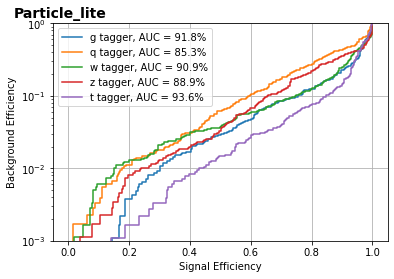

In [32]:
predict_test = model.predict(X_test)
predict_test = predict_test.transpose((1,0))
# y_test = y_test.transpose((1,0))
labels = ['j_g','j_q','j_w','j_z','j_t']
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[i]
    df[label + '_pred'] = predict_test[i]
    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
    auc1[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend(loc='upper left')
plt.ylim(0.001,1)
plt.grid(True)

plt.figtext(0.25, 0.90,'Particle_lite',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

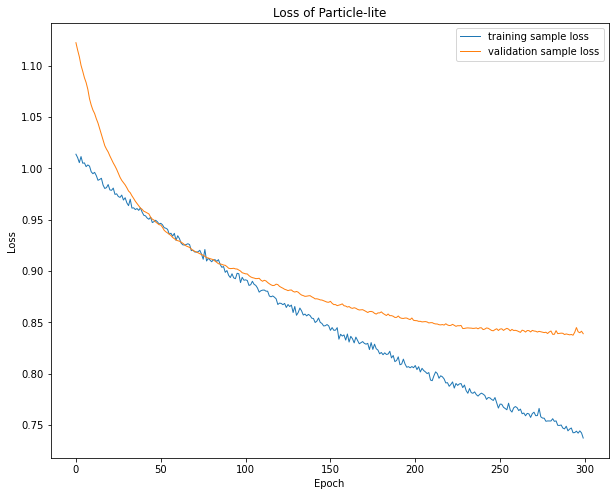

In [31]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Loss of Particle-lite')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
plt.show()
plt.close()